In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os
import nrrd

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np
import cv2

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
import keras.layers as tfkl
import keras_cv.layers as tfklcv
from tensorflow.keras.applications import ResNet50


# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

E0000 00:00:1735843558.907476    1038 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735843558.923787    1038 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.18.0


In [2]:
import tensorflow as tf
print("GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

GPUs Available:  1


Visualizing 5 Random Full Slice Images:


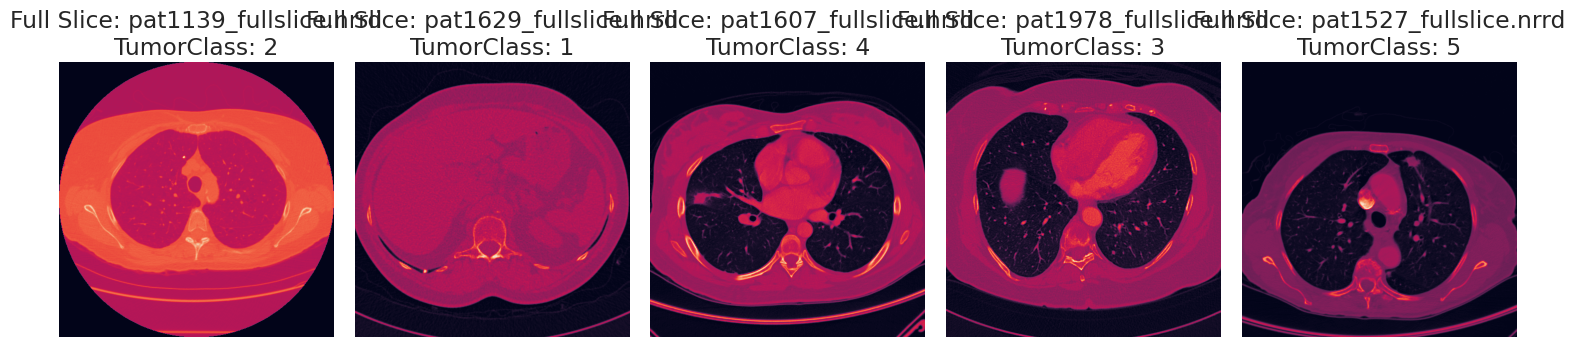

Visualizing 5 Random Nodule Images:


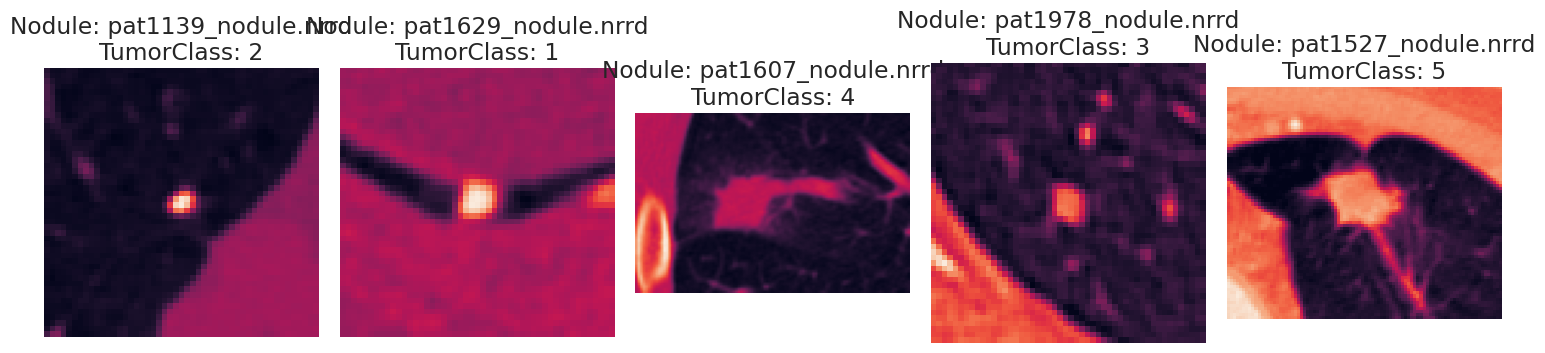

In [3]:
# Define paths
# Path to the folder containing .nrrd files and the .xls file
nrrd_folder = "Train"
xls_file = "dataset_lung.xlsx"

# Load the Excel file
patient_data = pd.read_excel(xls_file)

# Function to visualize a .nrrd file
def visualize_nrrd(nrrd_path, title):
    
    # Read the nrrd file
    data, header = nrrd.read(nrrd_path)
    
    # Check if data is 3D and extract a 2D slice
    if len(data.shape) == 3:
        middle_slice_index = data.shape[0] // 2  # Middle slice
        middle_slice = data[middle_slice_index, :, :]
    elif len(data.shape) == 2:
        middle_slice = data
    else:
        print(f"Unsupported data shape: {data.shape}")
        return
    
    # Plot the slice
    plt.imshow(middle_slice)
    plt.title(title)
    plt.axis("off")

# Function to plot 20 random images for a given column (Full_slice or Nodule)
def plot_random_images(data, image_column, title_prefix):
    # Randomly sample 20 rows
    random_sample = data.sample(n=5, random_state=42)

    # Plot the images
    plt.figure(figsize=(15, 15))
    for idx, (_, row) in enumerate(random_sample.iterrows()):
        image_file = os.path.join(nrrd_folder, row[image_column])
        plt.subplot(4, 5, idx + 1)  # 4 rows x 5 columns
        visualize_nrrd(image_file, f"{title_prefix}: {row[image_column]}\nTumorClass: {row['TumorClass']}")
    plt.tight_layout()
    plt.show()

# Plot Full_slice images
print("Visualizing 5 Random Full Slice Images:")
plot_random_images(patient_data, image_column='Full_slice', title_prefix="Full Slice")

# Plot Nodule images
print("Visualizing 5 Random Nodule Images:")
plot_random_images(patient_data, image_column='Nodule', title_prefix="Nodule")

In [4]:
def load_nrrd(file_path):
    """
    Loads an NRRD file and returns the data and header.
    
    Parameters:
        file_path (str): Path to the .nrrd file.

    Returns:
        tuple: A tuple containing:
            - data (numpy.ndarray): The image data.
            - header (dict): Metadata of the .nrrd file.
    """
    try:
        data, header = nrrd.read(file_path)
        print(f"NRRD file loaded successfully: {file_path}")
        return data, header
    except Exception as e:
        print(f"Error loading NRRD file: {file_path}. Error: {e}")
        return None, None

nrrd_file = "Full_Slices/pat1_fullslice.nrrd"
data, header = load_nrrd(nrrd_file)

if data is not None:
    print("Data shape:", data.shape)
    print("Header info:", header)

NRRD file loaded successfully: Full_Slices/pat1_fullslice.nrrd
Data shape: (512, 512)
Header info: OrderedDict([('type', 'int16'), ('dimension', 2), ('sizes', array([512, 512])), ('endian', 'little'), ('encoding', 'gzip')])


In [5]:
def plot_images(images, file_names, num_images=9):
    """
    Plots a specified number of images from the NumPy array.

    Parameters:
        images (numpy.ndarray): Array containing the images (num_images, height, width).
        file_names (list): List of file names corresponding to the images.
        num_images (int): Number of images to plot (default is 9).
    """
    num_images = min(num_images, len(images))
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(int(np.ceil(np.sqrt(num_images))), int(np.ceil(np.sqrt(num_images))), i + 1)
        plt.imshow(images[i], cmap="gray")
        plt.title(file_names[i], fontsize=8)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [6]:
def load_all_nrrd_images_with_labels(folder_path, labels_file):
    """
    Loads all NRRD images from a folder and their corresponding labels into a NumPy array.
    
    Parameters:
        folder_path (str): Path to the folder containing .nrrd files.
        labels_file (str): Path to the Excel file containing file names and labels.

    Returns:
        numpy.ndarray: Array containing all images, with shape (num_images, height, width).
        numpy.ndarray: Array containing the corresponding labels.
        list: List of file names corresponding to the images.
    """
    # Load labels from the Excel file
    labels_df = pd.read_excel(labels_file)
    labels_df['Full_slice'] = labels_df['Full_slice'].str.strip()  # Remove leading/trailing spaces
    labels_df.set_index('Full_slice', inplace=True)  # Use 'Full_slice' as the index

    images = []
    labels = []
    file_names = []
    
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".nrrd"):
            file_path = os.path.join(folder_path, file_name)
            try:
                # Read the NRRD file
                data, _ = nrrd.read(file_path)
                
                # Handle 3D images by taking the middle slice
                if len(data.shape) == 3:
                    middle_slice = data[data.shape[0] // 2, :, :]
                elif len(data.shape) == 2:
                    middle_slice = data
                else:
                    print(f"Skipping unsupported data shape {data.shape} in {file_name}")
                    continue
                
                # Normalize the image (scale pixel values to [0, 1])
                # middle_slice = middle_slice.astype(np.float32) / np.max(middle_slice)

                # Append the image and corresponding label
                if file_name in labels_df.index:
                    images.append(middle_slice)
                    labels.append(labels_df.loc[file_name, 'TumorClass'])
                    file_names.append(file_name)
                else:
                    print(f"No label found for {file_name}, skipping.")
            except Exception as e:
                print(f"Error loading image {file_name}: {e}")
                continue

    if images:
        images_array = np.stack(images, axis=0)  # Stack images into a single NumPy array
        labels_array = np.array(labels, dtype=np.int32)  # Labels as integers
        print(f"Loaded {len(images)} images with shape {images_array.shape} and labels with shape {labels_array.shape}")
        return images_array, labels_array, file_names
    else:
        print("No valid NRRD files found.")
        return None, None, []

# Example usage
folder_path = "Full_Slices"  # Path to your folder containing .nrrd files
labels_file = "dataset_lung.xlsx"  # Path to the labels file (Excel)

images_full_slices_v, labels_full_slices_v, file_names_full_slices_v = load_all_nrrd_images_with_labels(folder_path, labels_file)


Loaded 2363 images with shape (2363, 512, 512) and labels with shape (2363,)


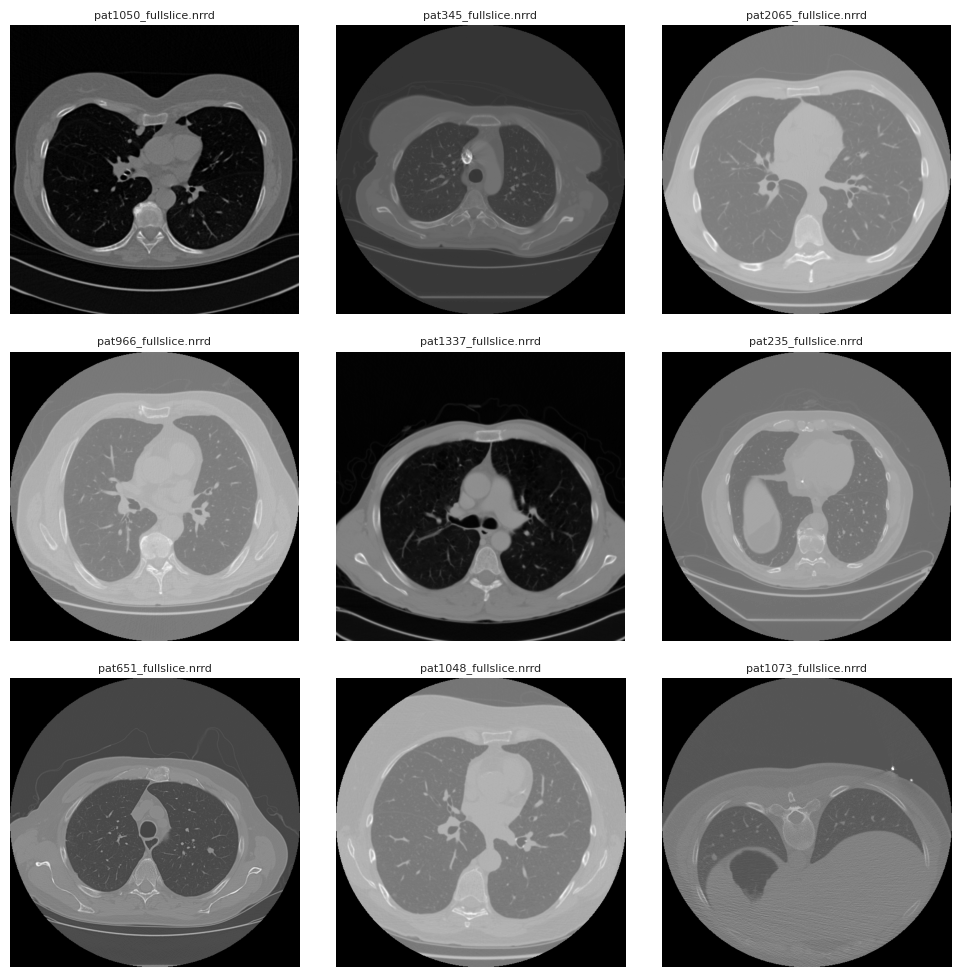

In [7]:
plot_images(images_full_slices_v, file_names_full_slices_v, num_images=9)

In [8]:
print(images_full_slices_v[0])

[[-1006  -993  -991 ... -1001 -1011 -1017]
 [-1013  -996 -1002 ...  -994 -1006 -1020]
 [-1020 -1000 -1008 ... -1000 -1011 -1014]
 ...
 [-1006 -1008 -1005 ... -1000  -999  -995]
 [ -997  -993  -996 ...  -996 -1001  -996]
 [ -991  -989 -1007 ... -1001  -999  -998]]


In [9]:
print(labels_full_slices_v[0], file_names_full_slices_v[0])
print(labels_full_slices_v[50], file_names_full_slices_v[50])

3 pat1050_fullslice.nrrd
2 pat406_fullslice.nrrd


In [10]:
def segment_lungs(ct_scan, lower_bound=-1000, upper_bound=-300):
    """
    Segments the lungs using HU thresholds.
    :param ct_scan: CT scan image in HU (numpy array).
    :param lower_bound: Lower bound in HU for lung tissue.
    :param upper_bound: Upper bound in HU for lung tissue.
    :return: Binary mask (numpy array) of the lungs.
    """
    # Apply the HU thresholds to create a binary mask
    lung_mask = np.logical_and(ct_scan >= lower_bound, ct_scan <= upper_bound)
    segmented_lungs = lung_mask.astype(np.uint8) * 255  # Convert to binary image (0 or 255)
    
    return segmented_lungs


Segmented lung masks array shape: (2363, 512, 512)


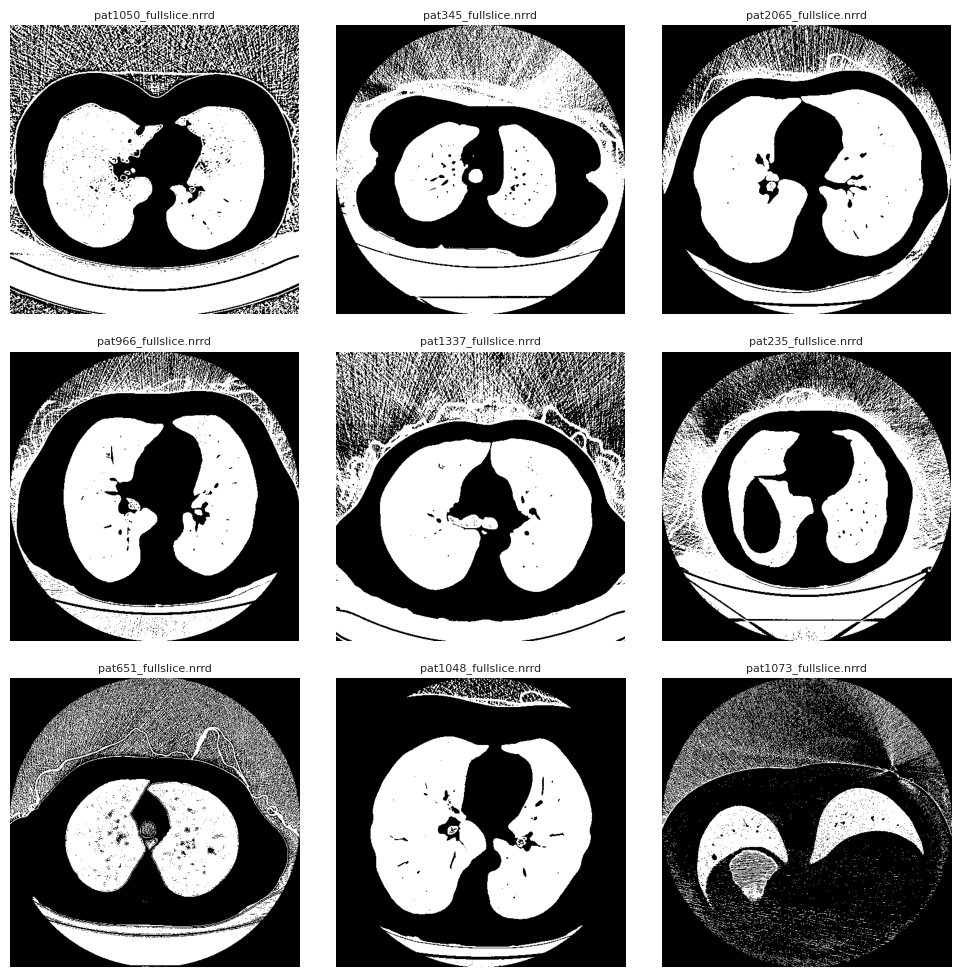

In [11]:
# Array to store the segmented lung masks
segmented_lungs_array = []
    
# Segment lungs for each image and store the result in an array
for i, image in enumerate(images_full_slices_v):
    segmented_lungs = segment_lungs(image)
    segmented_lungs_array.append(segmented_lungs)


# Convert the list of segmented lung masks to a NumPy array
segmented_lungs_array = np.array(segmented_lungs_array)
print(f"Segmented lung masks array shape: {segmented_lungs_array.shape}")
plot_images(segmented_lungs_array, file_names_full_slices_v, num_images=9)


In [12]:
def extract_lungs(img):
    # Step 1: Load the Image in Grayscale
    # img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Step 2: Apply Thresholding to Segment Lungs
    _, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)  # Invert to get white lungs
    
    # Step 3: Remove Small Artifacts with Morphological Operations
    kernel = np.ones((5, 5), np.uint8)  # Define a kernel
    cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)  # Remove small artifacts
    
    # Step 4: Find and Keep the Two Largest Contours (Lungs)
    contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]  # Keep 2 largest contours
    
    # Step 5: Create a Mask for the Lungs
    mask = np.zeros_like(img)
    cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)
    
    # Step 6: Refine the Mask (Optional - Gaussian Blur)
    mask = cv2.GaussianBlur(mask, (5, 5), 0)
    
    # Step 7: Extract the Lung Regions from the Original Image
    result = cv2.bitwise_and(img, img, mask=mask)
    
    return result

Segmented lung masks array shape: (2363, 512, 512)


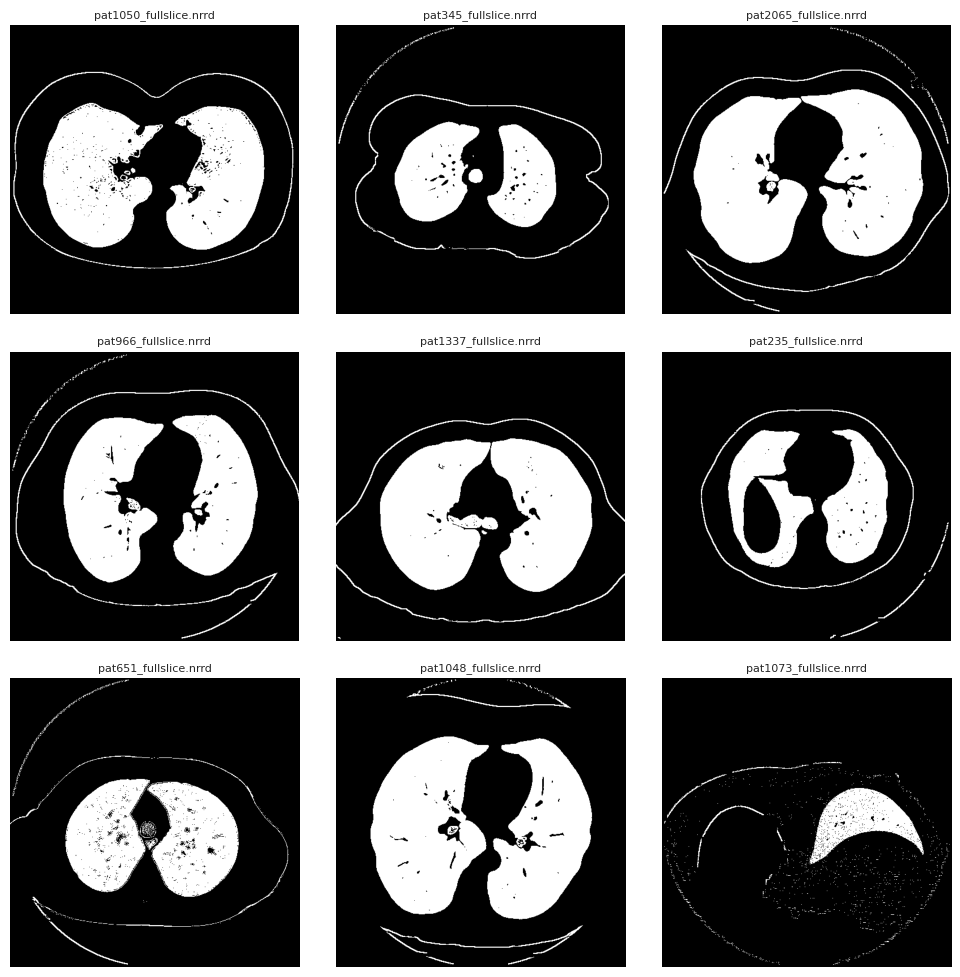

In [13]:
# Array to store the segmented lung masks
extract_lungs_array = []
    
# Segment lungs for each image and store the result in an array
for i, image in enumerate(segmented_lungs_array):
    open_lungs = extract_lungs(image)
    extract_lungs_array.append(open_lungs)


    
# Convert the list of segmented lung masks to a NumPy array
extract_lungs_array = np.array(extract_lungs_array)
print(f"Segmented lung masks array shape: {extract_lungs_array.shape}")
plot_images(extract_lungs_array, file_names_full_slices_v, num_images=9)

In [14]:
def apply_opening(mask, kernel_size=(5, 5)):
    """
    Applies opening operation (erosion followed by dilation) on a binary mask.
    :param mask: Binary mask (numpy array).
    :param kernel_size: Size of the structuring element for morphological operations.
    :return: Binary mask after opening operation.
    """
    # Define a kernel for morphological operations
    kernel = np.ones(kernel_size, np.uint8)
    
    # Perform opening: erosion followed by dilation
    opened_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    return opened_mask

Segmented lung masks array shape: (2363, 512, 512)


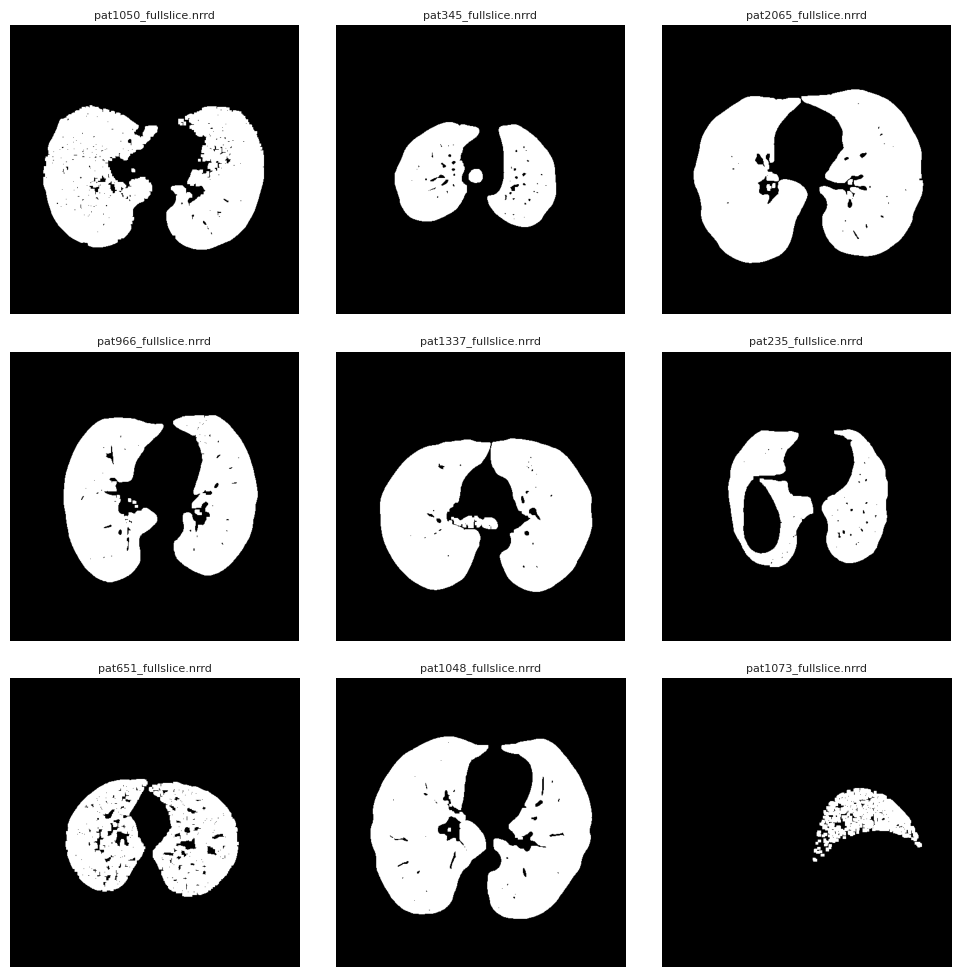

In [15]:
# Array to store the segmented lung masks
opening_lungs_array = []
    
# Segment lungs for each image and store the result in an array
for i, image in enumerate(extract_lungs_array):
    final_lungs = apply_opening(image)
    opening_lungs_array.append(final_lungs)


    
# Convert the list of segmented lung masks to a NumPy array
opening_lungs_array = np.array(opening_lungs_array)
print(f"Segmented lung masks array shape: {opening_lungs_array.shape}")
plot_images(opening_lungs_array, file_names_full_slices_v, num_images=9)

In [16]:
lungs_array_full = np.stack([opening_lungs_array] * 3, axis=-1)

print(f"New shape: {lungs_array_full.shape}")

New shape: (2363, 512, 512, 3)


Segmented lung mask for pat1629_fullslice.nrrd:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


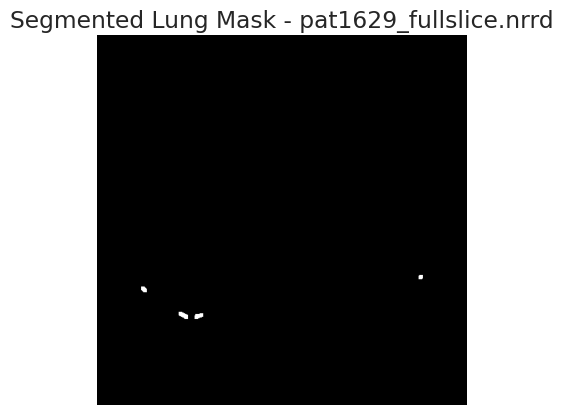

In [17]:
# Find the index of the file name
target_file_name = 'pat1629_fullslice.nrrd'
if target_file_name in file_names_full_slices_v:
    index = file_names_full_slices_v.index(target_file_name)
    
    # Access the corresponding segmented lung image
    target_image = opening_lungs_array[index]
    
    # Print the information
    print(f"Segmented lung mask for {target_file_name}:")
    print(target_image)
    
    # Optionally visualize the image
    import matplotlib.pyplot as plt
    plt.imshow(target_image, cmap='gray')
    plt.title(f"Segmented Lung Mask - {target_file_name}")
    plt.axis('off')
    plt.show()
else:
    print(f"File name '{target_file_name}' not found in the list.")


In [18]:
'''
def plot_images_with_labels(images, file_names, labels, title_prefix="Image", num_images=9):
    """
    Plots images with their corresponding labels (e.g., TumorClass).
    Args:
        images: NumPy array of images to plot.
        file_names: List of filenames corresponding to the images.
        labels: List of labels (e.g., TumorClass) for each image.
        title_prefix: Prefix for the image title.
        num_images: Number of images to plot (default: 9).
    """
    # Ensure the number of images does not exceed the provided list length
    num_images = min(num_images, len(images))
    
    plt.figure(figsize=(15, 15))
    for idx in range(num_images):
        plt.subplot(3, 3, idx + 1)  # Adjust grid for 9 images (3x3)
        plt.imshow(images[idx], cmap="gray")
        plt.title(f"{title_prefix}: {file_names[idx]}\nTumorClass: {labels[idx]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Extract TumorClass labels corresponding to the segmented lung masks
tumor_classes = [patient_data.loc[patient_data['Full_slice'] == file_name, 'TumorClass'].values[0]
                 for file_name in file_names_full_slices_v]

# Plot the segmented lung masks with TumorClass labels
print("Displaying segmented lung masks with TumorClass labels:")
plot_images_with_labels(opening_lungs_array, file_names_full_slices_v, tumor_classes, title_prefix="Segmented Lung")
'''


'\ndef plot_images_with_labels(images, file_names, labels, title_prefix="Image", num_images=9):\n    """\n    Plots images with their corresponding labels (e.g., TumorClass).\n    Args:\n        images: NumPy array of images to plot.\n        file_names: List of filenames corresponding to the images.\n        labels: List of labels (e.g., TumorClass) for each image.\n        title_prefix: Prefix for the image title.\n        num_images: Number of images to plot (default: 9).\n    """\n    # Ensure the number of images does not exceed the provided list length\n    num_images = min(num_images, len(images))\n    \n    plt.figure(figsize=(15, 15))\n    for idx in range(num_images):\n        plt.subplot(3, 3, idx + 1)  # Adjust grid for 9 images (3x3)\n        plt.imshow(images[idx], cmap="gray")\n        plt.title(f"{title_prefix}: {file_names[idx]}\nTumorClass: {labels[idx]}")\n        plt.axis("off")\n    plt.tight_layout()\n    plt.show()\n\n# Extract TumorClass labels corresponding to 

In [19]:
X_train, X_test, y_train, y_test = train_test_split(opening_lungs_array, labels_full_slices_v, test_size=0.3, random_state=42)

# Normalize data with EfficientNet preprocess input
X_train = tfk.applications.efficientnet.preprocess_input(X_train)
X_test =  tfk.applications.efficientnet.preprocess_input(X_test)
X_train = np.stack((X_train, X_train, X_train), axis=-1)
X_test = np.stack((X_test, X_test, X_test), axis=-1)

# Convert labels to categorical format using one-hot encoding
y_train = y_train - 1
y_test = y_test - 1
y_train = tfk.utils.to_categorical(y_train, num_classes=5)
y_test = tfk.utils.to_categorical(y_test, num_classes=5)

In [20]:
# y_train = np.argmax(y_train, axis=1)
# y_test = np.argmax(y_test, axis=1)

In [21]:
print(y_train[0])

[0. 0. 1. 0. 0.]


In [22]:
print(f"X_train:  {X_train.shape}")
print(f"X_test:  {X_test.shape}")
print(f"y_train:  {y_train.shape}")
print(f"y_test:  {y_test.shape}")

X_train:  (1654, 512, 512, 3)
X_test:  (709, 512, 512, 3)
y_train:  (1654, 5)
y_test:  (709, 5)


In [23]:
input_shape = X_train.shape[1:]  # Shape of a single image (height, width, channels)
print(input_shape)

(512, 512, 3)


In [24]:
# Number of training epochs
epochs = 1000

# Batch size for training
batch_size = 16

# Learning rate: step size for updating the model's weights
learning_rate = 0.00005

In [25]:
def build_model(
    input_shape=(512, 512, 3),
    num_classes=5,  # Number of tumor classes (1 to 5)
    learning_rate=1e-4,  # Define initial learning rate
):
    tf.random.set_seed(42)

    # Load EfficientNetV2S pretrained on ImageNet
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
    )

    # Freeze initial layers and unfreeze the last layers for fine-tuning
    for layer in base_model.layers[:int(len(base_model.layers) * 0.5)]:
        layer.trainable = False
    for layer in base_model.layers[int(len(base_model.layers) * 0.5):]:
        layer.trainable = True

    # Define the input layer and data augmentation
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    data_augmentation = tf.keras.Sequential([
        tfkl.RandomFlip('horizontal'),
        tfkl.RandomRotation(0.1),
        tfkl.RandomZoom(0.1),
        tfkl.RandomContrast(0.1),
        tfkl.GaussianNoise(0.05),
    ], name='data_augmentation')

    x = data_augmentation(input_layer)
    x = base_model(x, training=True)

    # Global pooling + Fully connected layers
    x = tfkl.GlobalAveragePooling2D(name='global_avg_pool')(x)
    x = tfkl.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-4), name='dense_1')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dropout(0.4)(x)
    x = tfkl.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-4), name='dense_2')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dropout(0.4)(x)
    x = tfkl.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-4), name='dense_3')(x)
    
    # Output layer for multi-class classification
    output_layer = tfkl.Dense(num_classes, activation='softmax', name='Output')(x)

    # Create the model
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='ResNet50_FineTuningModel')

    # Compile the model with appropriate loss and optimizer
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
    optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=1e-5)
    metrics = ['accuracy']
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    return model

# Build the model
model = build_model()

# Display the model architecture
model.summary()


I0000 00:00:1735843595.420219    1038 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "ResNet50_FineTuningModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 16, 16, 2048)   │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,804,741 (94.62 MB)

 Trainable params: 22,577,669 (86.13 MB)

 Non-trainable params: 2,227,072 (8.50 MB)

In [26]:
# Define the patience value for early stopping
patience = 15

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]

# Definir el scheduler para reducir la tasa de aprendizaje
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',   # Monitorizar la pérdida de validación
    factor=0.2,           # Reducir la tasa de aprendizaje a la mitad
    patience=8,           # Esperar 5 épocas sin mejora
    min_lr=1e-7           # Tasa de aprendizaje mínima
)

# Añadirlo a los callbacks existentes
callbacks.append(lr_scheduler)


In [27]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14379218780809102491
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5833228288
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7564233641301464796
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


I0000 00:00:1735843598.258992    1038 gpu_device.cc:2022] Created device /device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [28]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(labels_full_slices_v), y=labels_full_slices_v)
class_weights = dict(enumerate(class_weights))
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    class_weight = class_weights
)

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history.history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'weights.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/1000


I0000 00:00:1735843615.823718    1335 cuda_dnn.cc:529] Loaded cuDNN version 90300


104/104 ━━━━━━━━━━━━━━━━━━━━ 78s 556ms/step - accuracy: 0.2345 - loss: 2.2086 - val_accuracy: 0.2891 - val_loss: 1.7374 - learning_rate: 1.0000e-04
Epoch 2/1000
104/104 ━━━━━━━━━━━━━━━━━━━━ 51s 494ms/step - accuracy: 0.2426 - loss: 1.9883 - val_accuracy: 0.2426 - val_loss: 1.8745 - learning_rate: 1.0000e-04
Epoch 3/1000
104/104 ━━━━━━━━━━━━━━━━━━━━ 53s 506ms/step - accuracy: 0.2375 - loss: 1.9231 - val_accuracy: 0.2327 - val_loss: 2.0353 - learning_rate: 1.0000e-04
Epoch 4/1000
104/104 ━━━━━━━━━━━━━━━━━━━━ 51s 493ms/step - accuracy: 0.2346 - loss: 1.8333 - val_accuracy: 0.2087 - val_loss: 2.1771 - learning_rate: 1.0000e-04
Epoch 5/1000
104/104 ━━━━━━━━━━━━━━━━━━━━ 52s 505ms/step - accuracy: 0.2593 - loss: 1.8701 - val_accuracy: 0.3893 - val_loss: 2.4832 - learning_rate: 1.0000e-04
Epoch 6/1000
104/104 ━━━━━━━━━━━━━━━━━━━━ 51s 494ms/step - accuracy: 0.2428 - loss: 1.7716 - val_accuracy: 0.1636 - val_loss: 2.6373 - learning_rate: 1.0000e-04
Epoch 7/1000
104/104 ━━━━━━━━━━━━━━━━━━━━ 51s 4

31.02
38.93


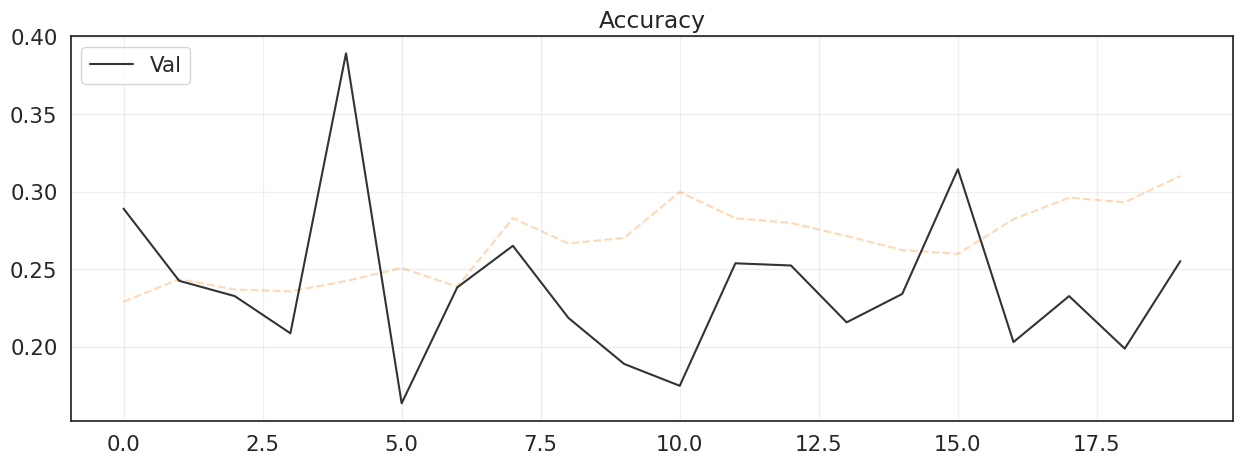

In [29]:
plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history.history['val_accuracy'], label='Val', alpha=.8, color='#000000')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

print(round(max(history.history['accuracy'])* 100, 2))
print(round(max(history.history['val_accuracy'])* 100, 2))

plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

def build_pretrained_model(input_shape, num_classes):
    """
    Builds a pre-trained ResNet50 model for lung cancer detection.

    Parameters:
        input_shape (tuple): Shape of the input images (height, width, channels).
        num_classes (int): Number of output classes.

    Returns:
        Model: A compiled Keras model.
    """
    # Load the ResNet50 model without the top layers
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model layers to preserve pre-trained weights
    base_model.trainable = False

    # Add custom layers for classification
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)  # Pass input through base model
    x = GlobalAveragePooling2D()(x)        # Global pooling layer
    x = Dropout(0.3)(x)                    # Add dropout for regularization
    outputs = Dense(num_classes, activation='softmax')(x)  # Output layer

    # Create the final model
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss.

    Parameters:
        history: History object returned by model.fit().
    """
    # Plot training and validation accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Load your data
segmented_lungs_array = np.array(segmented_lungs_array)  # Ensure it's a NumPy array
tumor_labels = np.array(tumor_classes)  # Labels: 0 (No tumor), 1 (Tumor)

# Normalize image data to [0, 1]
segmented_lungs_array = segmented_lungs_array / 255.0

# Add a channel dimension if images are grayscale
if len(segmented_lungs_array.shape) == 3:
    segmented_lungs_array = np.expand_dims(segmented_lungs_array, axis=-1)

# Define number of classes (e.g., tumor vs. no tumor)
num_classes = len(np.unique(tumor_labels))

# Split the data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(segmented_lungs_array, tumor_labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Build the pre-trained model
input_shape = X_train.shape[1:]  # Shape of a single image (height, width, channels)
print(input_shape)
model = build_pretrained_model(input_shape, num_classes)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Generate a classification report
y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred, target_names=["No Tumor", "Tumor"]))

# Plot training history
plot_training_history(history)
